In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def confirm_dates(start_date, end_date, GPS_df):
    
    tmp = np.where(GPS_df['date'] == start_date)
    if len(tmp[0]) == 0:
        event_start = []
    else:
        event_start = tmp[0][0]
        
    tmp = np.where(GPS_df['date'] == end_date)
    if len(tmp[0]) == 0:
        event_end = []
    else:
        event_end = tmp[0][0]
    
    n_start=1
    n_end=1
    
    while not event_start:
        tmp = np.where(GPS_df['date'] == (start_date - timedelta(days=n_start)))
        if len(tmp[0]) == 0:
            event_start = []
        else:
            event_start = tmp[0][0]
        n_start +=1
        if n_start > 10:
            event_start=[]
            break
        
    while not event_end:
        tmp = np.where(GPS_df['date'] == (end_date - timedelta(days=n_end)))
        if len(tmp[0]) == 0:
            event_end = []
        else:
            event_end = tmp[0][0]
        n_end +=1
        if n_end > 10:
            event_end=[]
            break
            
    GPS_start = 0
    GPS_end = 0
    
    if event_start and event_end:
        if GPS_df.index.isin([event_start - 150]).any():
            GPS_start = event_start - 150
        else:
            GPS_start = GPS_df.index[0]
        if GPS_df.index.isin([event_end + 150]).any():
            GPS_end = event_end + 150
        else: GPS_end = GPS_df.index[-1]
    
    return event_start, event_end, GPS_start, GPS_end
        

In [3]:
station_dates = pd.read_csv('2007_jul.csv')
station_dates['Start Date'] = pd.to_datetime(station_dates['Start Date'])
station_dates['Start Date'] = station_dates['Start Date'].dt.date
station_dates['End Date'] = pd.to_datetime(station_dates['End Date'])
station_dates['End Date'] = station_dates['End Date'].dt.date
station_dates = station_dates.sort_values(by = 'Lat')
station_dates['dN'] = ""
station_dates['dE'] = ""

In [47]:
station_dates

,Name,Data Available,Lat,Lon,Start Date,End Date,dN,dE
31,P315,Yes,39.863583,-123.716896,2007-07-18,2007-08-06,,
33,P317,Yes,39.905670,-123.551849,2007-07-18,2007-08-06,,
47,P344,Yes,39.929123,-122.027969,2007-07-18,2007-08-06,,
34,P322,No,39.962143,-123.182480,1991-12-10,1991-12-10,,
71,QUIN,Yes,39.974600,-120.944400,2007-07-18,2007-08-06,,
...,...,...,...,...,...,...,...,...
60,P373,Yes,43.622520,-123.333275,2007-07-24,2007-08-05,,
67,P389,No,43.811993,-120.603363,1991-12-10,1991-12-10,,
3,LFLO,Yes,43.983600,-124.107700,2007-07-24,2007-08-05,,
64,P383,No,44.342186,-122.217224,1991-12-10,1991-12-10,,


(13558.0, 13885.0)

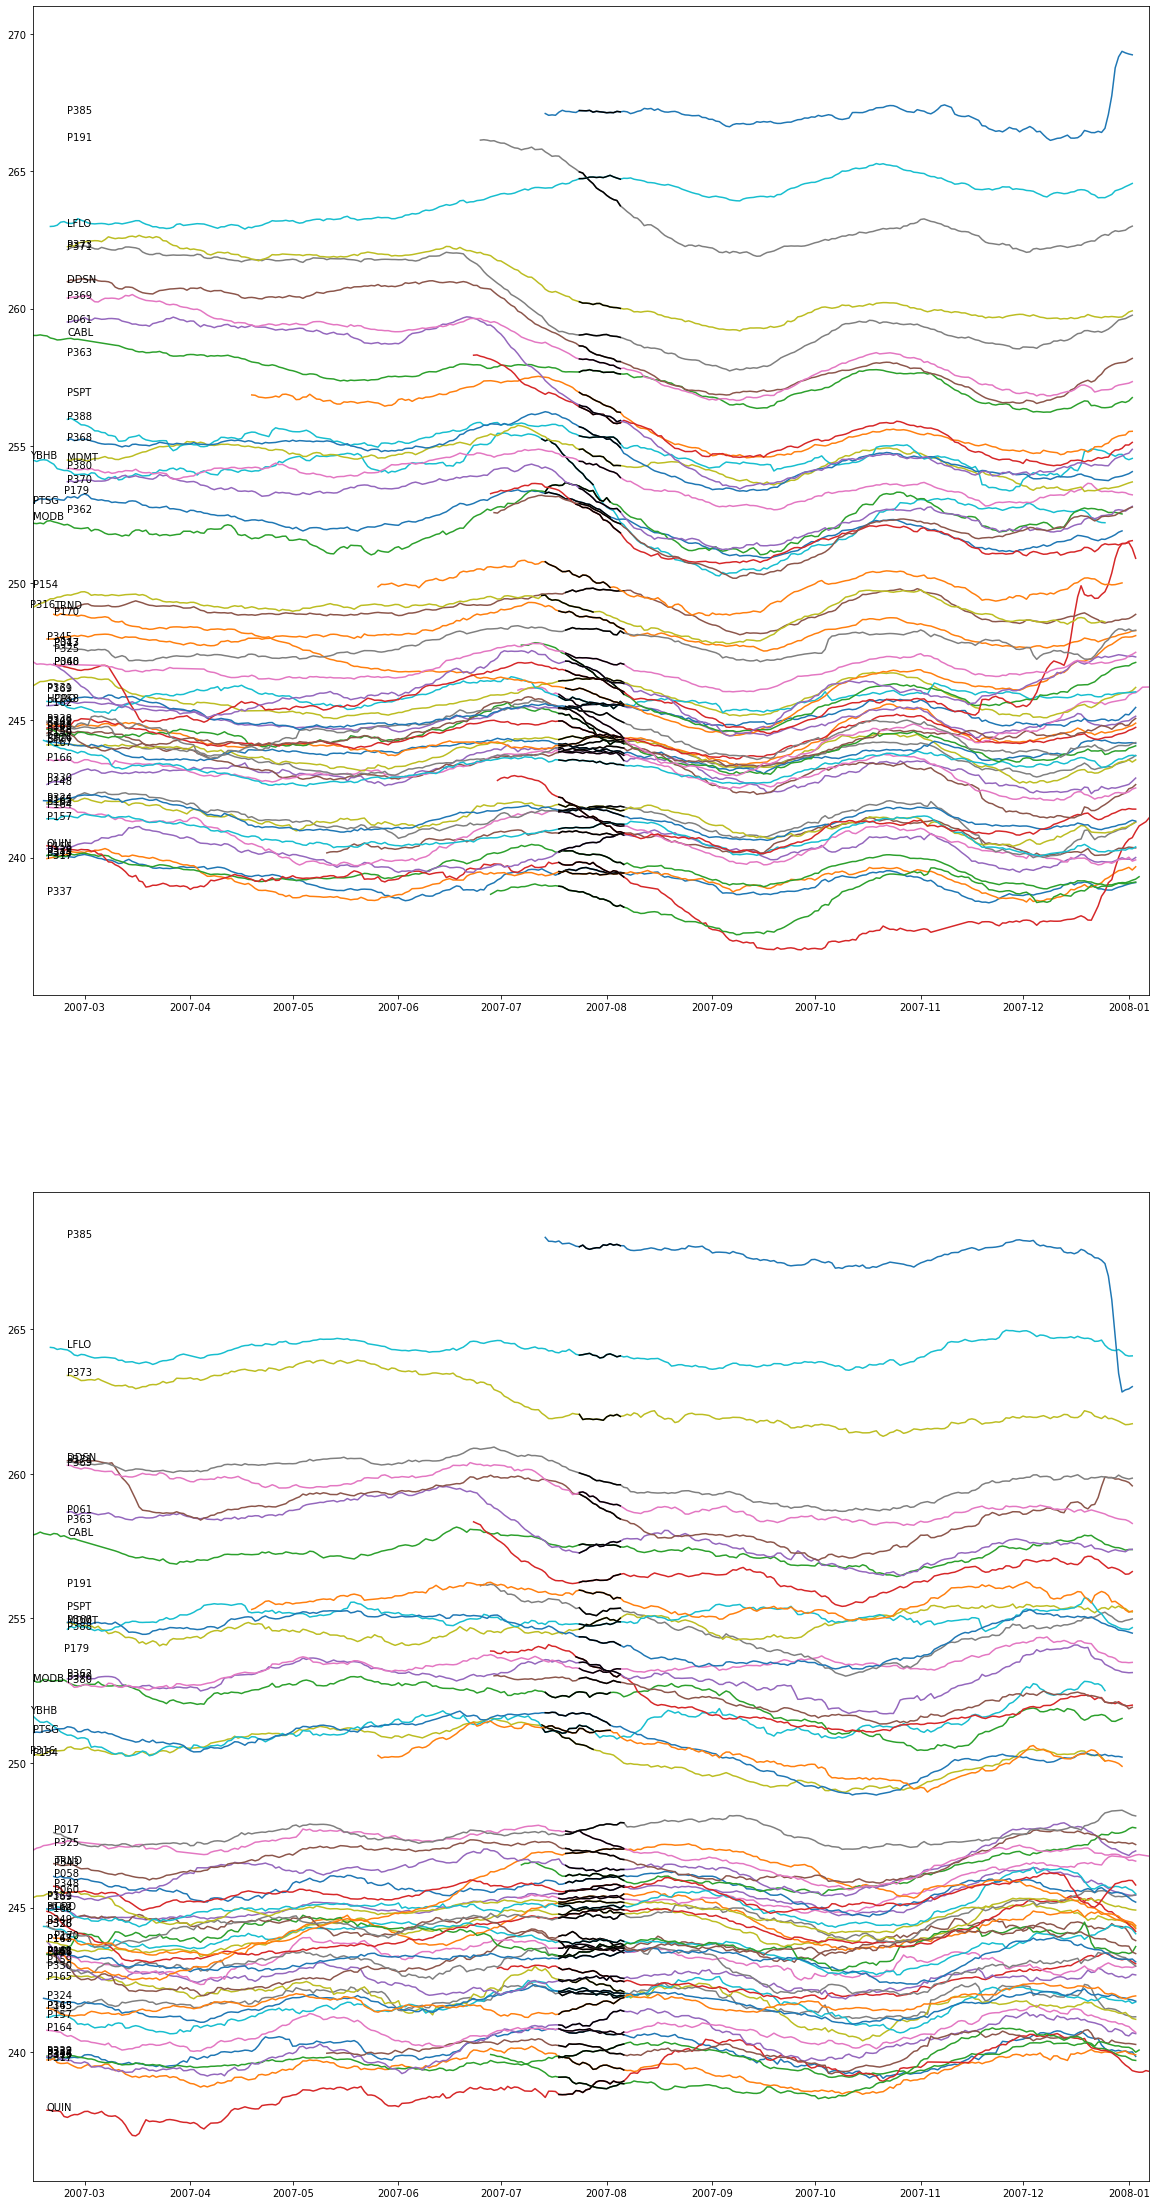

In [4]:
pd.options.mode.chained_assignment = None

plt.figure(figsize=(20,40))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)

for index, row in station_dates.iterrows():
    
    file = row['Name'] + '_cleaned.txt'
    GPS_df = pd.read_csv(file, header=None, delim_whitespace=True, names=['date','date time','N','E','U',
                                                                                       'sN','sE','sU'])
    GPS_df['date']=pd.to_datetime(GPS_df['date'])
    GPS_df['date']=GPS_df['date'].dt.date
    GPS_df.drop('date time', axis=1, inplace=True)
    
    start_date = row['Start Date']
    end_date = row['End Date']
    tmp = np.where(GPS_df['date'] == start_date)
    
    event_start, event_end, start_idx, end_idx = confirm_dates(start_date, end_date, GPS_df)
    
    if event_start and event_end:
    
        ax1.plot(GPS_df['date'].loc[start_idx:end_idx],GPS_df['E'].loc[start_idx:end_idx]+row['Lat']*6)
        ax2.plot(GPS_df['date'].loc[start_idx:end_idx],GPS_df['N'].loc[start_idx:end_idx]+row['Lat']*6)
        ax1.plot(GPS_df['date'].loc[event_start:event_end],GPS_df['E'].loc[event_start:event_end]+row['Lat']*6,'k')
        ax2.plot(GPS_df['date'].loc[event_start:event_end],GPS_df['N'].loc[event_start:event_end]+row['Lat']*6,'k')
    
        text_date = GPS_df['date'].loc[event_start]-timedelta(days=150)
        ax1.text(text_date ,GPS_df['E'].loc[start_idx]+row['Lat']*6, row['Name'])
        ax2.text(text_date ,GPS_df['N'].loc[start_idx]+row['Lat']*6, row['Name'])
    
        north_disp = GPS_df['N'].iloc[event_end+1:event_end+10].mean() - GPS_df['N'].iloc[event_start-10:event_start-1].mean()
        east_disp = GPS_df['E'].iloc[event_end+1:event_end+10].mean() - GPS_df['E'].iloc[event_start-10:event_start-1].mean()
        
        station_dates.loc[index,'dN'] = north_disp
        station_dates.loc[index,'dE'] = east_disp
        
        if not station_dates.loc[index,'dN'] or not station_dates.loc[index,'dE']:
            station_dates.loc[index,'Data Available'] = 'No'
    
    else:
        
        station_dates.loc[index,'Data Available'] = 'No'
        
ax1.set_xlim(GPS_df.loc[event_start,'date'] - timedelta(days=160), GPS_df.loc[event_end,'date'] + timedelta(days=155))
ax1.set_xlim(GPS_df.loc[event_start,'date'] - timedelta(days=160), GPS_df.loc[event_end,'date'] + timedelta(days=155))
ax2.set_xlim(GPS_df.loc[event_start,'date'] - timedelta(days=160), GPS_df.loc[event_end,'date'] + timedelta(days=155))
ax2.set_xlim(GPS_df.loc[event_start,'date'] - timedelta(days=160), GPS_df.loc[event_end,'date'] + timedelta(days=155))
    

(-126.0, -120.5)

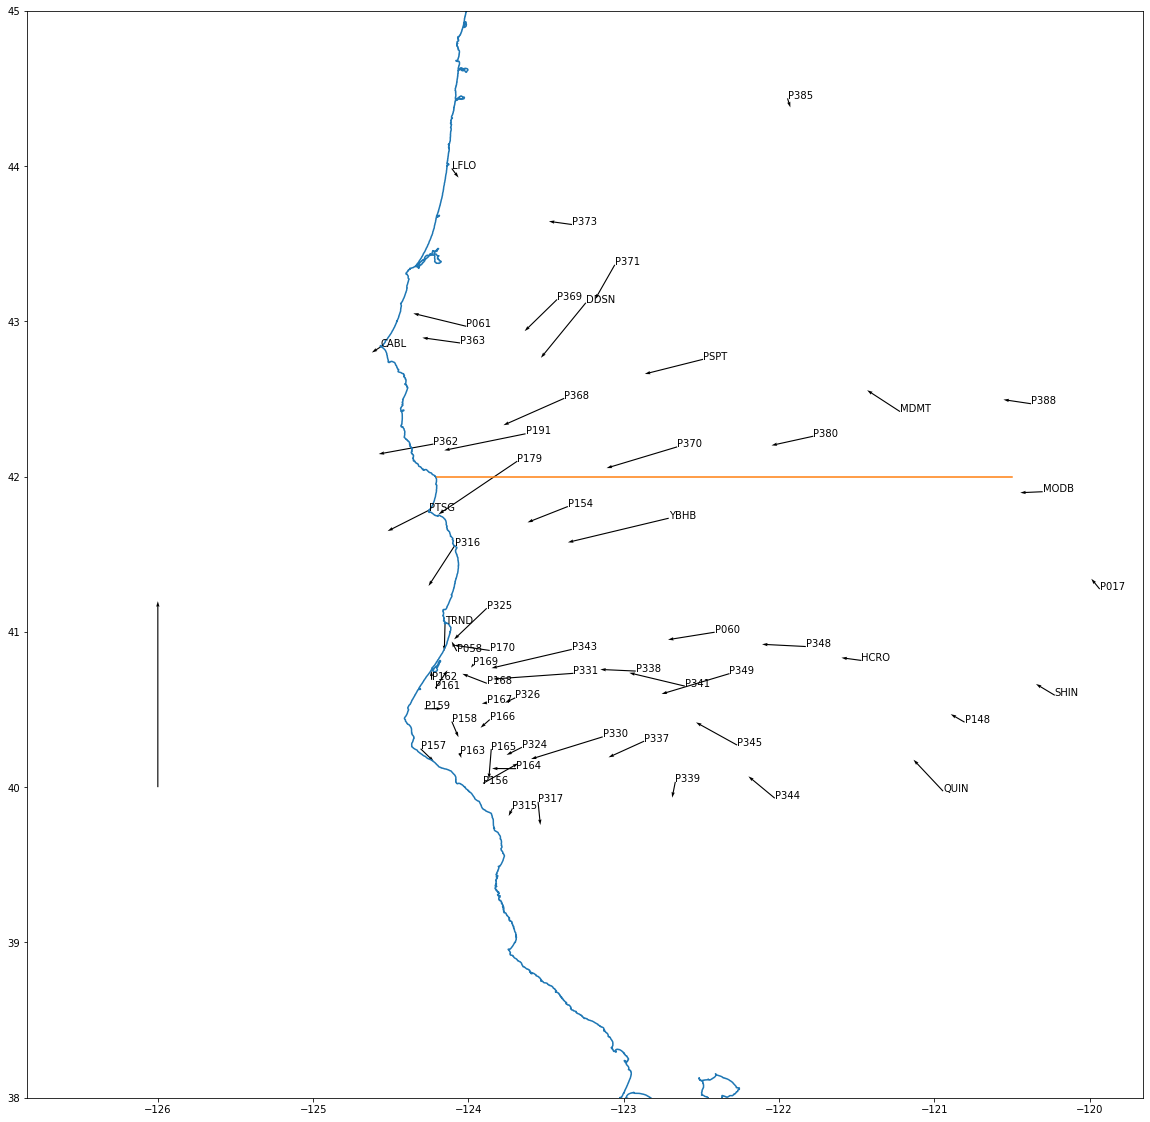

In [5]:
mask = station_dates['Data Available'] == 'Yes'
station_dates = station_dates[mask]
coast_df = pd.read_csv('PNWcoast.dat',delim_whitespace=True, header=None, names=['lon', 'lat'])

fig, ax = plt.subplots(figsize=(20,20))
ax.plot(coast_df['lon'],coast_df['lat'])

for index, row in station_dates.iterrows():

    ax.quiver(row['Lon'],row['Lat'],row['dE'],row['dN'], scale=30, width = 0.001)
    ax.text(row['Lon'],row['Lat'],row['Name'])

ax.plot([-124.2,-120.5],[42,42])
ax.quiver(-126,40,0,5, scale=30, width=0.001)
ax.axis('equal')
ax.set_ylim(38,45)
ax.set_xlim(-126,-120.5)


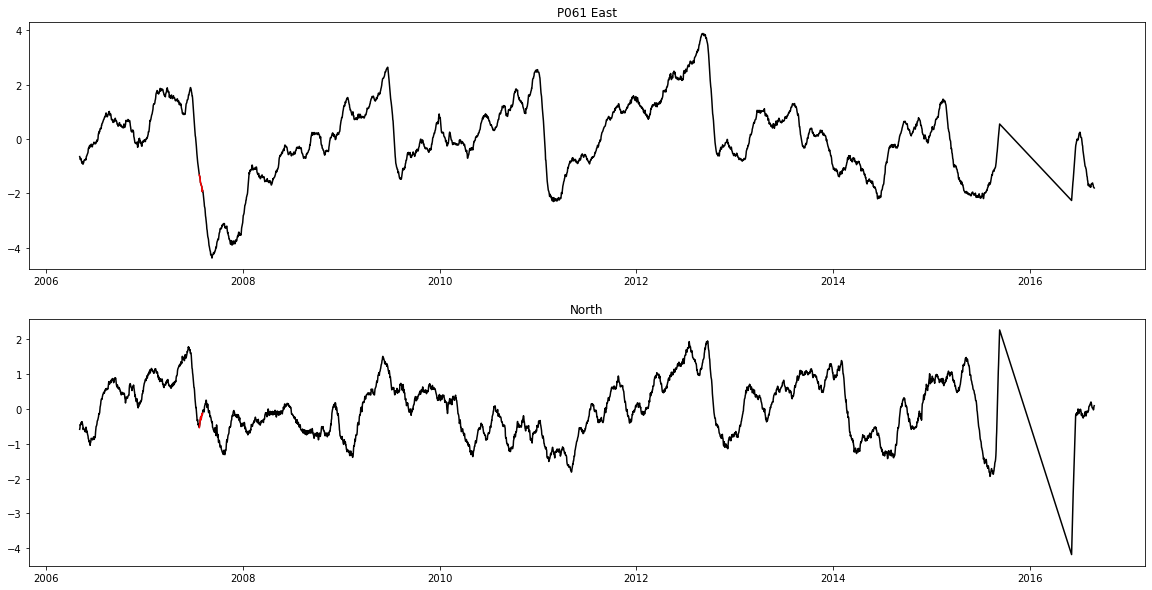

In [ ]:
for index, row in station_dates.iterrows():
    
    file = row['Name'] + '_cleaned.txt'
    GPS_df = pd.read_csv(file, header=None, delim_whitespace=True, names=['date','date time','N','E','U',
                                                                                       'sN','sE','sU'])
    GPS_df['date']=pd.to_datetime(GPS_df['date'])
    GPS_df['date']=GPS_df['date'].dt.date
    GPS_df.drop('date time', axis=1, inplace=True)
    
    start_date = row['Start Date']
    end_date = row['End Date']
    tmp = np.where(GPS_df['date'] == start_date)
    
    event_start, event_end, start_idx, end_idx = confirm_dates(start_date, end_date, GPS_df)
    
    
    fig, ax = plt.subplots(2,1,figsize=(20,10))

    if event_start and event_end:
    
        ax[0].plot(GPS_df['date'],GPS_df['E'],'k')
        ax[1].plot(GPS_df['date'],GPS_df['N'],'k')
        ax[0].plot(GPS_df['date'].loc[event_start:event_end],GPS_df['E'].loc[event_start:event_end],'r')
        ax[1].plot(GPS_df['date'].loc[event_start:event_end],GPS_df['N'].loc[event_start:event_end],'r')
        ax[0].title.set_text(row['Name'] + ' East')
        ax[1].title.set_text('North')
    
    plt.show()
    input("Enter")
    clear_output()
